In [4]:
import pandas as pd
import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import resize



# Paths

In [5]:
cur_dirpath: str = os.path.abspath(".")
data_dirpath: str = os.path.join(
    cur_dirpath,
    "test-data"
)

lc_data_dirpath: str = os.path.join(data_dirpath, "lc")
apl_data_dirpath: str = os.path.join(data_dirpath, "apl")


In [6]:
# dot_np: np.ndarray = np.expand_dims(np.asarray(Image.open("./dot.png").convert("L")), 0)
# dot_np.shape
# dot_np = preprocess(dot_np)
# np.save("dot", dot_np)

In [7]:
dot_np = np.load("dot.npy")


In [8]:

apl_paths: list[str] = list(map(lambda p: os.path.join(apl_data_dirpath, p), os.listdir(apl_data_dirpath)))
apl_metadata_path: str = apl_paths[0]
apl_paths = apl_paths[1:]


In [9]:
lc_labels_csv_path: str = os.path.join(cur_dirpath, "test-data", "lc", "metadata.csv")
lc_labels_df: pd.DataFrame = pd.read_csv(lc_labels_csv_path)

lc_paths: list[str] = list(map(lambda p: os.path.join(lc_data_dirpath, p), os.listdir(lc_data_dirpath)))
lc_metadata_path: str = lc_paths[0]
lc_paths = lc_paths[1:]


In [10]:
lc_labels_df["fullpath"] = lc_labels_df["filename"].apply(lambda x: os.path.join(lc_data_dirpath, x))

In [11]:
lc_labels_df

,filename,line,fullpath
0,V3-10304.png,λavftd.(λpo.(λrfxv.cwlq)je)n,c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
1,V3-10236.png,(λzickd.wuq)(λc.r),c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
2,V3-11868.png,λbsr.((λu.j)(λs.tchn)(λk.lupr))zj,c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
3,V3-10614.png,λm.v(λtyla.nd)du,c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
4,V3-13679.png,(λmxfw.c)(λdc.((λd.c)(λqcgda.p))),c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
...,...,...,...
259,r-64.png,λtg.g,c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
260,r-65.png,λa.λb.aa,c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
261,r-66.png,λf.(λx.f(xx))(λx.f(xx)),c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...
262,r-67.png,λn.nn,c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-m...


# Preprocess

In [12]:
def preprocess_characters(image: npt.NDArray[np.ubyte]) -> list[tuple[str, npt.NDArray[np.ubyte], str]]:
    """
    Preprocess a grayscale image to extract individual character components.
    
    The image is expected to be a single-line grayscale image (H×W) with a white background (255)
    and text as darker pixels. This function performs connected-component labelling using
    a simple disjoint set (union‑find) algorithm, merges overlapping components via an adjacency
    matrix, extracts bounding boxes for each glyph, pads them by 1 pixel, and returns a list of tuples.
    
    Returns:
        List of tuples (prefix, character_image, suffix), where prefix and suffix are empty strings.
    """
    # Helper function: disjoint-set union "find" with path compression.
    def get_root(parent: npt.NDArray, i: int, j: int) -> tuple[int, int]:
        root = parent[i, j]
        if (root[0], root[1]) != (i, j):
            root = get_root(parent, root[0], root[1])
            parent[i, j] = root  # Path compression.
        return (root[0], root[1])
    
    # Create a binary mask where True indicates a foreground pixel.
    # Here, we assume background is white (255) and foreground is any pixel not equal to 255.
    data = image != 255
    h, w = data.shape

    # Create a parent matrix for the union-find structure.
    # Each pixel gets its own parent initially; shape: (h, w, 2)
    parent = np.zeros((h, w, 2), dtype=int)
    for i in range(h):
        for j in range(w):
            parent[i, j] = [i, j]  # Initialize parent as self.
            if not data[i, j]:
                continue  # Skip background.
            # Check top and left neighbours.
            neighbours = []
            if i >= 1 and data[i - 1, j]:
                neighbours.append((i - 1, j))
            if j >= 1 and data[i, j - 1]:
                neighbours.append((i, j - 1))
            if len(neighbours) == 0:
                continue
            # Convert each neighbour to its root.
            for idx, (ni, nj) in enumerate(neighbours):
                neighbours[idx] = get_root(parent, ni, nj)
            # Set current pixel's parent as the first neighbour's root.
            parent[i, j] = neighbours[0]
            # If there is a second neighbour, merge by setting its root's parent to the first.
            if len(neighbours) > 1:
                n2 = neighbours[1]
                parent[n2[0], n2[1]] = neighbours[0]

    # Convert the parent matrix to a 1D label vector.
    parent_flat = np.multiply(parent, [w, 1]).sum(axis=2).ravel()
    # Apply path compression iteratively until convergence.
    q = parent_flat[parent_flat]
    while not np.array_equiv(parent_flat, q):
        parent_flat = q
        q = parent_flat[parent_flat]

    # Create an initial label map; background pixels (False in data) remain zero.
    s = data.ravel() * (parent_flat + 1)
    comp_ids = np.sort(np.unique(s))
    s = np.searchsorted(comp_ids, s)

    # For each component (ignoring background 0), compute leftmost and rightmost column indices.
    num_components = len(comp_ids) - 1  # background is 0.
    left_indices = np.zeros(num_components)
    right_indices = np.zeros(num_components)
    for comp in range(1, len(comp_ids)):
        cols_in_comp = np.argwhere(s == comp).ravel() % w
        left_indices[comp - 1] = cols_in_comp.min()
        right_indices[comp - 1] = cols_in_comp.max()

    # Build an adjacency matrix between components.
    # Components are considered "adjacent" if one's left edge is greater or equal to the other's,
    # and either its right edge is less or equal or its left edge is within half the width of the other.
    b = np.logical_and(
        np.greater_equal.outer(left_indices, left_indices),
        np.logical_or(
            np.less_equal.outer(right_indices, right_indices),
            np.less_equal.outer(left_indices, left_indices + 0.5 * (right_indices - left_indices))
        )
    )
    # Make the relationship undirected.
    b = np.logical_or(b, b.T)
    # Compute transitive closure.
    bb = b.dot(b)
    while not np.array_equiv(b, bb):
        b = bb
        bb = b.dot(b)

    # Merge connected labels based on the adjacency matrix.
    for comp in range(1, len(comp_ids)):
        indices = np.argwhere(s == comp).ravel()
        new_label = np.nonzero(b[comp - 1, :])[0][0] + 1
        s[indices] = new_label

    # Recompute unique component ids and reshape the label map.
    comp_ids = np.sort(np.unique(s))
    s = np.searchsorted(comp_ids, s).reshape((h, w))

    # Extract bounding boxes for each component (ignoring background).
    glyphs = []
    for comp in range(1, len(comp_ids)):
        coords = np.argwhere(s == comp)
        min_y, min_x = coords.min(axis=0)
        max_y, max_x = coords.max(axis=0)
        # Create the glyph image.
        # For the region, set pixels equal to the component id to False (background) and invert.
        glyph_img = 255 * np.logical_not(s[min_y:max_y+1, min_x:max_x+1] == comp)
        glyphs.append((min_x, max_x, glyph_img))

    # Sort glyphs from left to right by the left boundary.
    glyphs.sort(key=lambda x: x[0])
    glyph_images = [g[2] for g in glyphs]

    # Pad each glyph with a border of 1 pixel (padding with white, 255).
    glyph_images = [np.pad(glyph, ((1, 1), (1, 1)), constant_values=255) for glyph in glyph_images]

    # Wrap each glyph image into a tuple (prefix, image, suffix).
    # For this self-contained function, prefixes and suffixes are empty strings.
    output = [('', glyph, '') for glyph in glyph_images]
    return output

In [13]:
def preprocess(char_np: np.ndarray, threshold=0.001) -> np.ndarray:
    pad = 1
    image_dims = (64, 64)
    
    # char_np is expected to have shape (1, h, w)
    # Crop the image around the black pixels (foreground).
    # Since the foreground is black (values near 0) and background is white (near 1),
    # we use a threshold of 0.5 so that pixels < 0.5 are considered foreground.
    mask = char_np < 0.5
    # mask has shape (1, h, w). Use np.nonzero to get indices.
    # np.nonzero returns a tuple (channel_idx, row_idx, col_idx)
    channels, rows, cols = np.nonzero(mask)
    if rows.size > 0 and cols.size > 0:
        r_min, r_max = rows.min(), rows.max()
        c_min, c_max = cols.min(), cols.max()
        # Crop along the height and width dimensions while keeping the channel.
        cropped = char_np[:, r_min:r_max+1, c_min:c_max+1]
    else:
        # If no foreground pixels are found, return the original image.
        cropped = char_np

    # Convert the cropped image to a torch tensor.
    # This assumes the image is already normalised (e.g. values in [0, 1]).
    image_tensor = torch.from_numpy(cropped).float()

    # Compute the target size by subtracting 2 * pad (one for each side)
    # from each desired dimension in self.image_dims.
    target_size = [d - pad * 2 for d in image_dims]
    image_resized = resize(image_tensor, target_size, antialias=True)

    # Apply threshold and cast types.
    # First, threshold the image. Then cast to torch.uint8 and back to torch.float32.
    image_thresh = (image_resized > threshold).to(torch.uint8).to(torch.float32)

    # Pad the image.
    # The pad tuple is (pad_left, pad_right, pad_top, pad_bottom).
    image_padded = F.pad(
        image_thresh,
        (pad, pad, pad, pad),
        mode='constant',
        value=1.0
    )
    
    return image_padded



In [14]:

lc_words: list[np.ndarray] = []
lc_labels: list[str] = []

for row in lc_labels_df.iterrows():
    row = row[1]
    
    im_path: str = row["fullpath"]
    im_label: str= row["line"]
    
    im_pil: Image.Image = Image.open(im_path)
    
    im_np: npt.NDArray[np.ubyte] = np.asarray(im_pil)

    if im_np.ndim == 3:
        im_np = im_np.max(axis=-1)
    
    char_list = preprocess_characters(255 - im_np)
    if char_list is None:
        continue
    
    char_list = (x[1] for x in char_list)
    
    fixed_char_list = [] 
       
    for char in char_list:
        
        if char.min() == char.max():
            # broken cus just a dot
            char = 1.0 - dot_np.copy()
        
        char = np.expand_dims(char, 0)
        char = preprocess(char)
        
        fixed_char_list.append(char)
    if len(fixed_char_list) == 0:
        print("Ivalid")
        continue
    word: np.ndarray = np.stack(fixed_char_list, axis=0)
    
    lc_labels.append(im_label)
    lc_words.append(word)
    

Ivalid
Ivalid
Ivalid
Ivalid
Ivalid
Ivalid
Ivalid
Ivalid
Ivalid
Ivalid


In [21]:
dot_match = np.asarray(
    [[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]]
)

In [22]:
fixed_lc_words = []


for word in lc_words:
    
    
    new_chars = []
    for char in word:
        
        if np.all(char == dot_match):
            char = dot_np
            
        new_chars.append(char)
        
        #plt.imshow(char[0, :, :], cmap="gray")
        #plt.show()
    
    fixed_lc_words.append(np.stack(new_chars, 0))


# Load ONNX

In [23]:
import onnxruntime
import numpy as np
import numpy.typing as npt

cnn_lc_onnx_file_path = "KrudCNN_LC_Prod.onnx"
rcnn_lc_onnx_file_path = "KrudCRNN_LC_Prod.onnx" 
cnn_py_onnx_file_path = "KrudCNN_Py_Prod.onnx" 
cnn_apl_onnx_file_path = "KrudCNN_APL_Prod.onnx"
cnn_sara_lc_onnx_file_path = "CNN_LC_SaraFix_M.onnx"
cnn_template_lc_onnx_file_path = "template_lambda_calculus_char.onnx"

providers = ['CPUExecutionProvider']

# Create the InferenceSession with the explicit providers
cnn_lc_onnx = onnxruntime.InferenceSession(cnn_lc_onnx_file_path, providers=providers)
rcnn_lc_onnx = onnxruntime.InferenceSession(rcnn_lc_onnx_file_path, providers=providers)
cnn_py_onnx = onnxruntime.InferenceSession(cnn_py_onnx_file_path, providers=providers)
cnn_apl_onnx = onnxruntime.InferenceSession(cnn_apl_onnx_file_path, providers=providers)
cnn_sara_lc_onnx = onnxruntime.InferenceSession(cnn_sara_lc_onnx_file_path, providers=providers)
cnn_template_lc_onnx = onnxruntime.InferenceSession(cnn_sara_lc_onnx_file_path, providers=providers)

# Prepare the input image
input_image: npt.NDArray[np.float32] = np.random.random(
    (
        1,  # batch: stack as many images as you like here
        1,  # channels: needs to be 1 (grayscale), pixels are 1.0 or 0.0
        64, # height: fixed to 64 pixels for now
        64  # width: fixed to 64 pixels for now
    )
).astype(np.float32)

input_seq_image = np.random.random(
    (
        1,  # batch: stack as many images as you like here
        1,  # seq
        1,  # channels: needs to be 1 (grayscale), pixels are 1.0 or 0.0
        64, # height: fixed to 64 pixels for now
        64  # width: fixed to 64 pixels for now
    )
).astype(np.float32)


# Run inference
cnn_lc_inputs: list[onnxruntime.NodeArg] = cnn_lc_onnx.get_inputs()
cnn_lc_outputs: list[onnxruntime.NodeArg] = cnn_lc_onnx.get_outputs()
cnn_lc_input_name: list[str] = cnn_lc_inputs[0].name
cnn_lc_output_names: list[str] = [out.name for out in cnn_lc_outputs]

cnn_py_inputs: list[onnxruntime.NodeArg] = cnn_py_onnx.get_inputs()
cnn_py_outputs: list[onnxruntime.NodeArg] = cnn_py_onnx.get_outputs()
cnn_py_input_name: list[str] = cnn_py_inputs[0].name
cnn_py_output_names: list[str] = [out.name for out in cnn_py_outputs]

rcnn_lc_inputs: list[onnxruntime.NodeArg] = rcnn_lc_onnx.get_inputs()
rcnn_lc_outputs: list[onnxruntime.NodeArg] = rcnn_lc_onnx.get_outputs()
rcnn_lc_input_name: list[str] = rcnn_lc_inputs[0].name
rcnn_lc_output_names: list[str] = [out.name for out in rcnn_lc_outputs]

cnn_apl_inputs: list[onnxruntime.NodeArg] = cnn_apl_onnx.get_inputs()
cnn_apl_outputs: list[onnxruntime.NodeArg] = cnn_apl_onnx.get_outputs()
cnn_apl_input_name: list[str] = cnn_apl_inputs[0].name
cnn_apl_output_names: list[str] = [out.name for out in cnn_apl_outputs]

cnn_sara_lc_inputs: list[onnxruntime.NodeArg] = cnn_sara_lc_onnx.get_inputs()
cnn_sara_lc_outputs: list[onnxruntime.NodeArg] = cnn_sara_lc_onnx.get_outputs()
cnn_sara_lc_input_name: list[str] = cnn_sara_lc_inputs[0].name
cnn_sara_lc_output_names: list[str] = [out.name for out in cnn_sara_lc_outputs]

cnn_template_lc_inputs: list[onnxruntime.NodeArg] = cnn_template_lc_onnx.get_inputs()
cnn_template_lc_outputs: list[onnxruntime.NodeArg] = cnn_template_lc_onnx.get_outputs()
cnn_template_lc_input_name: list[str] = cnn_template_lc_inputs[0].name
cnn_template_lc_output_names: list[str] = [out.name for out in cnn_template_lc_outputs]



# Running Inference

lc cnn

rcnn lc

In [ ]:
rcnn_classes = list('()+-.0123456789:<=>[]abcdefghijklmnopqrstuvwxyz\{\}×÷λ')
cnn_sara_classes = list('∀∃().0123456789:λμabcdefghijklmnopqrstuvwxyz')
apl_classes = list('!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~£¨¯´·×÷←↑→↓∆∇∊∘∣∧∨∩∪≠≡≢≤≥⊂⊃⊖⊢⊣⊤⊥⋄⌈⌊⌶⌷⌹⌽⌿⍀⍉⍋⍎⍒⍕⍙⍝\\⍞⍟⍣⍨⍪⍫⍬⍱⍲⍳⍴⍵⍷⍺⎕○')
py_classes = list('')

# New Testing

In [ ]:

for word, label in zip(fixed_lc_words, lc_labels):
    
    if word.shape[0] != len(label):
        continue
    
    
    print(word.shape)
    cnn_preds = []
    cnn_sara_pred = []
    
    for char in word:
        char = 1.0 - char
        
        cnn_logits = cnn_lc_onnx.run(
            cnn_lc_output_names, 
            {cnn_lc_input_name: np.expand_dims(char, 0)}
        )[0]
        
        cnn_sara_logits = cnn_sara_lc_onnx.run(
            cnn_sara_lc_output_names, 
            {cnn_sara_lc_input_name: np.expand_dims(char, 0)}
        )[0]
        
        print(cnn_sara_logits)
        
        char_y_hat = chr(int(cnn_logits[0, 0]))
        char_sara_y_hat = chr(int(cnn_sara_classes[np.argmax(cnn_sara_logits[0])]))
        
        cnn_preds.append(char_y_hat)
        cnn_sara_pred.append(char_sara_y_hat)
        
    cnn_y_hat = ''.join(cnn_preds)
    cnn_sara_y_hat = ''.join(cnn_preds)
    
    word = np.expand_dims(word, 0)
    
    print(word.shape) # (1, 10, 1, 64, 64) batch, seq, channel, height, width
    

    print(f"pred (cnn)       = {cnn_y_hat}")
    print(f"pred (cnn_sara)  = {cnn_sara_y_hat}")
    print(f"label            = {label}")
    

(10, 1, 64, 64)
[[-6.68534184e+00 -1.38910365e+00 -1.71809177e+01 -3.00836778e+00
  -1.20262842e+01 -1.44118767e+01 -3.74155402e+00 -6.67726374e+00
  -1.14400311e+01 -3.16091704e+00 -1.04758854e+01 -1.43925123e+01
  -3.73363090e+00 -1.50266285e+01 -3.43700695e+00 -1.23631153e+01
   8.69486427e+00 -1.26190856e-01 -1.30721831e+00 -9.86660671e+00
  -1.24015579e+01 -1.57400393e+00 -1.46041498e+01 -6.19730711e+00
  -5.44354820e+00 -2.88711429e+00 -7.86132288e+00 -8.65024090e+00
  -7.61461163e+00 -1.48150797e+01 -8.29736519e+00 -6.59631348e+00
  -1.43748922e+01 -2.97031283e+00 -2.72568130e+00 -1.05742579e+01
  -8.47040844e+00 -1.52713394e+01 -3.51931024e+00 -9.50487900e+00
  -6.51758051e+00 -2.82352185e+00 -8.63739476e-03 -9.44865704e+00]]


ValueError: chr() arg not in range(0x110000)

# Old Testing

In [ ]:

softmax: np.ndarray
softmax_ordered: np.ndarray
cnn_logits: np.ndarray

for word, label in zip(fixed_lc_words, lc_labels):
    
    if word.shape[0] != len(label):
        continue
    
    
    print(word.shape)
    cnn_preds = []
    cnn2_preds = []
    for char in word:
        char = 1.0 - char
        cnn_logits = cnn_lc_onnx.run(
            cnn_lc_output_names, 
            {cnn_lc_input_name: np.expand_dims(char, 0)}
        )[0]
        char_y_hat = chr(int(cnn_logits[0, 0]))
        
        char2_y_hat = char_y_hat 
        if char2_y_hat in ("+", "×"):
            char2_y_hat = "x"
        if char2_y_hat in ("0", "9", "6"):
            char2_y_hat = "."
        if char2_y_hat in ("8",):
            char2_y_hat = "e"
        
        if char2_y_hat in ("1", "2", "7", "4"):
            char2_y_hat = "λ"
        
        
        cnn_preds.append(char_y_hat)
        cnn2_preds.append(char2_y_hat)
        
    cnn_y_hat = ''.join(cnn_preds)
    cnn2_y_hat = ''.join(cnn2_preds)
    
    word = np.expand_dims(word, 0)
    
    print(word.shape) # (1, 10, 1, 64, 64) batch, seq, channel, height, width
    cnn_logits = rcnn_lc_onnx.run(
        rcnn_lc_output_names, 
        {rcnn_lc_input_name: word}
    )[0]
    top_pred_indexes: list[int] = cnn_logits.argmax(axis=-1).squeeze().tolist()
    
    rcnn_y_hat: str = "".join([rcnn_classes[c] for c in top_pred_indexes])
    
    
    
    print(f"pred (r-cnn) = {rcnn_y_hat}")
    print(f"pred (cnn)   = {cnn_y_hat}")
    print(f"pred (cnn2)  = {cnn2_y_hat}")
    print(f"label        = {label}")
    

    


(10, 1, 64, 64)
(1, 10, 1, 64, 64)
pred (r-cnn) = λooacogoao
pred (cnn)   = λa.q(4q.d)
pred (cnn2)  = λa.q(λq.d)
label        = λa.a(λa.a)
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = λaoog
pred (cnn)   = λdadd
pred (cnn2)  = λdadd
label        = λd.dd
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = λbgog
pred (cnn)   = λkj.j
pred (cnn2)  = λkj.j
label        = λkj.j
(7, 1, 64, 64)
(1, 7, 1, 64, 64)
pred (r-cnn) = λpogoog
pred (cnn)   = λ+.4y.+
pred (cnn2)  = λx.λy.x
label        = λx.λy.x
(4, 1, 64, 64)
(1, 4, 1, 64, 64)
pred (r-cnn) = λgog
pred (cnn)   = λg.g
pred (cnn2)  = λg.g
label        = λg.g
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = omgom
pred (cnn)   = λms.m
pred (cnn2)  = λms.m
label        = λms.m
(12, 1, 64, 64)
(1, 12, 1, 64, 64)
pred (r-cnn) = coogoocobgoo
pred (cnn)   = (λy.y)(1b.b)
pred (cnn2)  = (λy.y)(λb.b)
label        = (λy.y)(λb.b)
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = ggpop
pred (cnn)   = 15r.s
pred (cnn2)  = λ5r.s
label        = λsr.s
(12, 1, 

In [20]:
def fix_cnn_char(c: str) -> str:
    if c in ("+", "×"):
        c = "x"
    if c in ("0", "9", "6"):
        c = "."
    if c in ("8",):
        c = "e"
    if c in ("1", "2", "7", "4"):
        c = "λ"
    return c

In [ ]:
# Tracking correct predictions and total counts
rcnn_correct = 0
cnn_correct = 0
cnn2_correct = 0
total_chars = 0

for word, label in zip(fixed_lc_words, lc_labels):
    if word.shape[0] != len(label):
        continue

    print(word.shape)

    cnn_preds = []
    cnn2_preds = []
    for char in word:
        char = 1.0 - char
        cnn_logits = cnn_lc_onnx.run(
            cnn_lc_output_names, 
            {cnn_lc_input_name: np.expand_dims(char, 0)}
        )[0]
        char_y_hat = chr(int(cnn_logits[0, 0]))
        cnn_top3_chars = [chr(int(x)) for x in cnn_logits[:3, 0].tolist()]
        cnn2_top3_chars = [fix_cnn_char(chr(int(x))) for x in cnn_logits[:3, 0].tolist()]
        
        char2_y_hat = fix_cnn_char(char_y_hat)
        

        cnn_preds.append(char_y_hat)
        cnn2_preds.append(char2_y_hat)

    cnn_y_hat = ''.join(cnn_preds)
    cnn2_y_hat = ''.join(cnn2_preds)

    word = np.expand_dims(word, 0)

    print(word.shape)
    cnn_logits = rcnn_lc_onnx.run(
        rcnn_lc_output_names, 
        {rcnn_lc_input_name: word}
    )[0]
    top_pred_indexes = cnn_logits.argmax(axis=-1).squeeze().tolist()
    top3_preds = np.argsort(cnn_logits, axis=-1)[..., ::-1][0, :, :3]
    
    rcnn_y_hat = ''.join([rcnn_classes[c] for c in top_pred_indexes])

    print(f"pred (r-cnn) = {rcnn_y_hat}")
    print(f"pred (cnn)   = {cnn_y_hat}")
    print(f"pred (cnn2)  = {cnn2_y_hat}")
    print(f"label        = {label}")

    # Calculate char-wise accuracy
    for i, true_char in enumerate(label):
        if i < len(rcnn_y_hat) and rcnn_y_hat[i] == true_char:
            rcnn_correct += 1
        if i < len(cnn_y_hat) and cnn_y_hat[i] == true_char:
            cnn_correct += 1
        if i < len(cnn2_y_hat) and cnn2_y_hat[i] == true_char:
            cnn2_correct += 1
        total_chars += 1


NameError: name 'fixed_lc_words' is not defined

In [ ]:
# Initialise counters
rcnn_correct = 0
cnn_correct = 0
cnn2_correct = 0

rcnn_top3_correct = 0
cnn_top3_correct = 0
cnn2_top3_correct = 0

total_chars = 0

for word, label in zip(fixed_lc_words, lc_labels):
    if word.shape[0] != len(label):
        continue

    print(word.shape)

    cnn_preds = []
    cnn2_preds = []
    cnn_top3_list = []
    cnn2_top3_list = []

    for char in word:
        char = 1.0 - char

        cnn_logits = cnn_lc_onnx.run(
            cnn_lc_output_names,
            {cnn_lc_input_name: np.expand_dims(char, 0)}
        )[0]  # shape: (N, 1), where N are unicode values

        cnn_logits = cnn_logits[:, 0]  # flatten shape (N,)
        top3_vals = cnn_logits[:3]  # model already returns sorted top unicode values

        # Top-1
        char_y_hat = chr(int(top3_vals[0]))

        # Top-3 chars (raw + fixed for cnn2)
        cnn_top3_chars = [chr(int(x)) for x in top3_vals.tolist()]
        cnn2_top3_chars = [fix_cnn_char(c) for c in cnn_top3_chars]

        # Apply fix for CNN2 top-1
        char2_y_hat = fix_cnn_char(char_y_hat)

        cnn_preds.append(char_y_hat)
        cnn2_preds.append(char2_y_hat)

        cnn_top3_list.append(cnn_top3_chars)
        cnn2_top3_list.append(cnn2_top3_chars)

    cnn_y_hat = ''.join(cnn_preds)
    cnn2_y_hat = ''.join(cnn2_preds)

    # RCNN inference
    word = np.expand_dims(word, 0)
    print(word.shape)

    cnn_logits = rcnn_lc_onnx.run(
        rcnn_lc_output_names,
        {rcnn_lc_input_name: word}
    )[0]  # shape: (1, seq_len, num_classes)

    top_pred_indexes = cnn_logits.argmax(axis=-1).squeeze().tolist()
    top3_preds = np.argsort(cnn_logits, axis=-1)[..., ::-1][0, :, :3]

    rcnn_y_hat = ''.join([rcnn_classes[c] for c in top_pred_indexes])

    print(f"pred (r-cnn) = {rcnn_y_hat}")
    print(f"pred (cnn)   = {cnn_y_hat}")
    print(f"pred (cnn2)  = {cnn2_y_hat}")
    print(f"label        = {label}")

    # Accuracy tracking
    for i, true_char in enumerate(label):
        total_chars += 1

        # RCNN
        if i < len(rcnn_y_hat):
            if rcnn_y_hat[i] == true_char:
                rcnn_correct += 1
            top3_chars = [rcnn_classes[idx] for idx in top3_preds[i]]
            if true_char in top3_chars:
                rcnn_top3_correct += 1

        # CNN
        if i < len(cnn_y_hat):
            if cnn_y_hat[i] == true_char:
                cnn_correct += 1
            if true_char in cnn_top3_list[i]:
                cnn_top3_correct += 1

        # CNN2
        if i < len(cnn2_y_hat):
            if cnn2_y_hat[i] == true_char:
                cnn2_correct += 1
            if true_char in cnn2_top3_list[i]:
                cnn2_top3_correct += 1

# Results
print("\n--- Character-wise Accuracy ---")
print(f"RCNN  Top-1: {rcnn_correct}/{total_chars} ({rcnn_correct / total_chars:.2%})")
print(f"RCNN  Top-3: {rcnn_top3_correct}/{total_chars} ({rcnn_top3_correct / total_chars:.2%})")

print(f"CNN   Top-1: {cnn_correct}/{total_chars} ({cnn_correct / total_chars:.2%})")
print(f"CNN   Top-3: {cnn_top3_correct}/{total_chars} ({cnn_top3_correct / total_chars:.2%})")

print(f"CNN2  Top-1: {cnn2_correct}/{total_chars} ({cnn2_correct / total_chars:.2%})")
print(f"CNN2  Top-3: {cnn2_top3_correct}/{total_chars} ({cnn2_top3_correct / total_chars:.2%})")



(10, 1, 64, 64)
(1, 10, 1, 64, 64)
pred (r-cnn) = λooacogoao
pred (cnn)   = λa.q(4q.d)
pred (cnn2)  = λa.q(λq.d)
label        = λa.a(λa.a)
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = λaoog
pred (cnn)   = λdadd
pred (cnn2)  = λdadd
label        = λd.dd
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = λbgog
pred (cnn)   = λkj.j
pred (cnn2)  = λkj.j
label        = λkj.j
(7, 1, 64, 64)
(1, 7, 1, 64, 64)
pred (r-cnn) = λpogoog
pred (cnn)   = λ+.4y.+
pred (cnn2)  = λx.λy.x
label        = λx.λy.x
(4, 1, 64, 64)
(1, 4, 1, 64, 64)
pred (r-cnn) = λgog
pred (cnn)   = λg.g
pred (cnn2)  = λg.g
label        = λg.g
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = omgom
pred (cnn)   = λms.m
pred (cnn2)  = λms.m
label        = λms.m
(12, 1, 64, 64)
(1, 12, 1, 64, 64)
pred (r-cnn) = coogoocobgoo
pred (cnn)   = (λy.y)(1b.b)
pred (cnn2)  = (λy.y)(λb.b)
label        = (λy.y)(λb.b)
(5, 1, 64, 64)
(1, 5, 1, 64, 64)
pred (r-cnn) = ggpop
pred (cnn)   = 15r.s
pred (cnn2)  = λ5r.s
label        = λsr.s
(12, 1, 

In [82]:
help(np.argsort)

Help on _ArrayFunctionDispatcher in module numpy:

argsort(a, axis=-1, kind=None, order=None)
    Returns the indices that would sort an array.
    
    Perform an indirect sort along the given axis using the algorithm specified
    by the `kind` keyword. It returns an array of indices of the same shape as
    `a` that index data along the given axis in sorted order.
    
    Parameters
    ----------
    a : array_like
        Array to sort.
    axis : int or None, optional
        Axis along which to sort.  The default is -1 (the last axis). If None,
        the flattened array is used.
    kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
        Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
        and 'mergesort' use timsort under the covers and, in general, the
        actual implementation will vary with data type. The 'mergesort' option
        is retained for backwards compatibility.
    
        .. versionchanged:: 1.15.0.
           T

In [ ]:
cnn_logits.shape

(1, 12, 52)

In [ ]:
cnn_logits.argsort(axis=-1) 

(1, 12, 52)

In [85]:
print(label)




(λb.b)(λo.o)
[44 45 24]
[ 0 40 31]
[51 44 37]
[31 44 40]
[44 51 49]
[31 41 24]
[51 44  1]
[ 0 31 40]
[51 44 31]
[31 44 41]
[44 51 31]
[31  0 41]


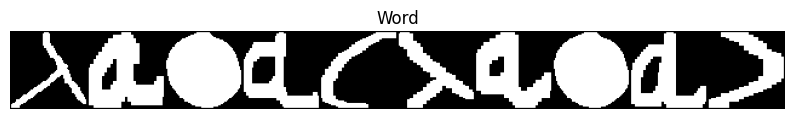

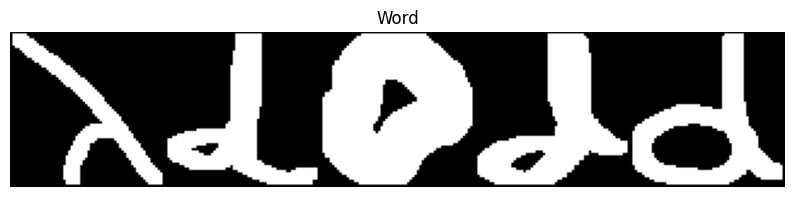

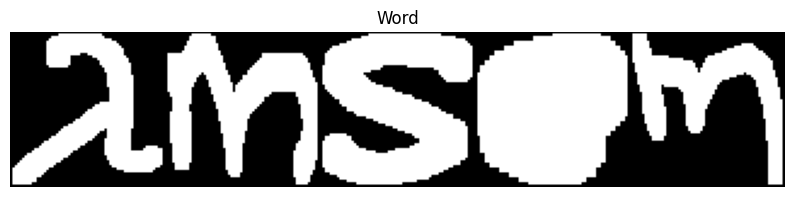

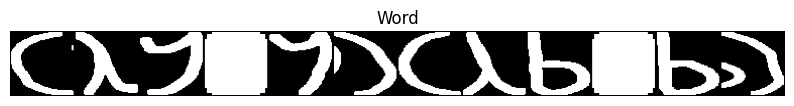

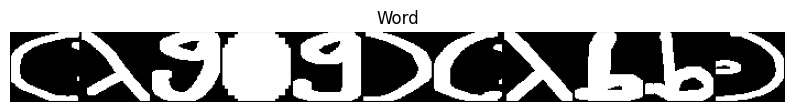

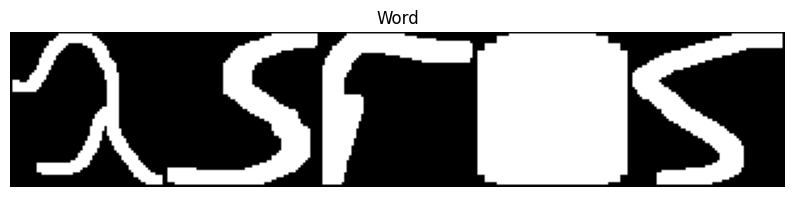

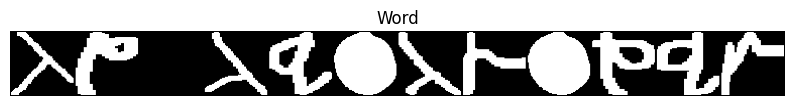

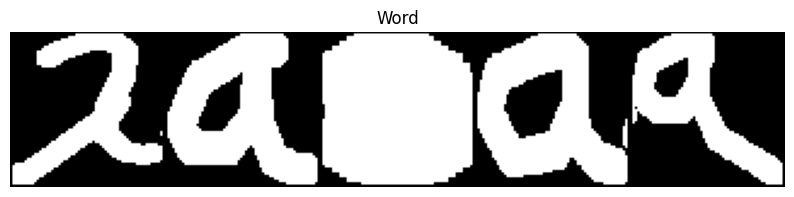

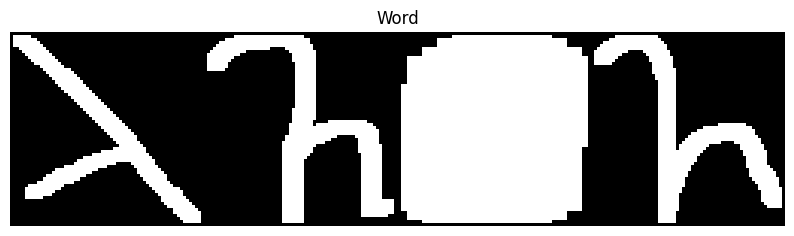

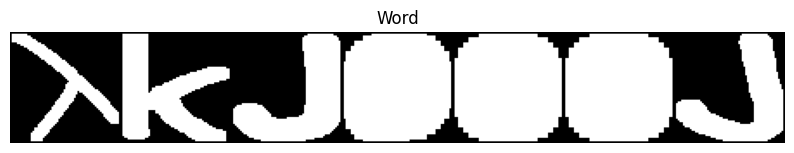

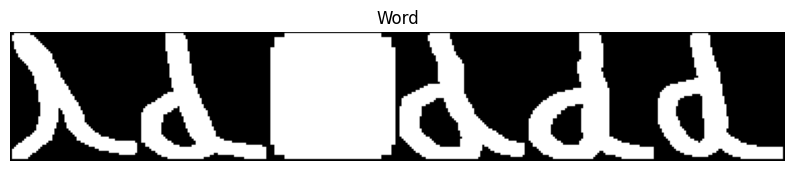

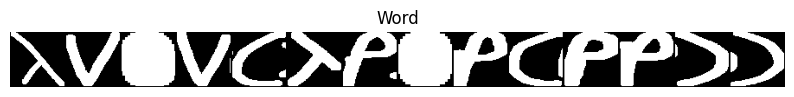

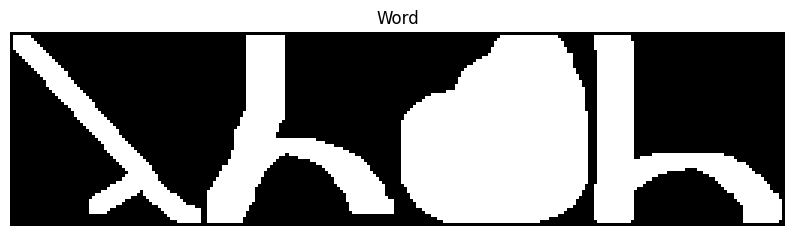

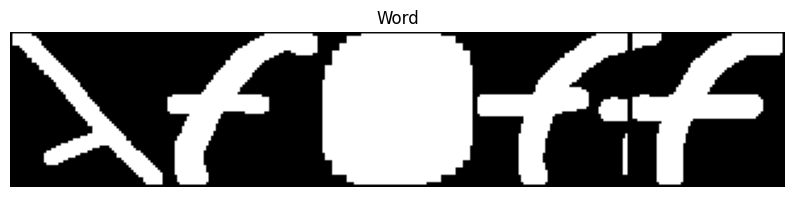

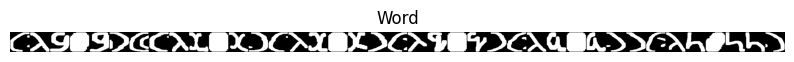

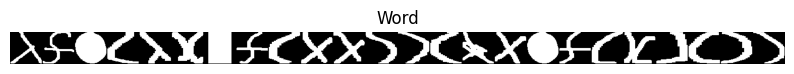

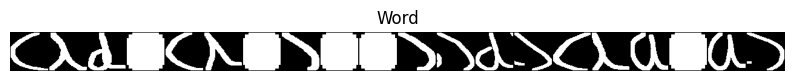

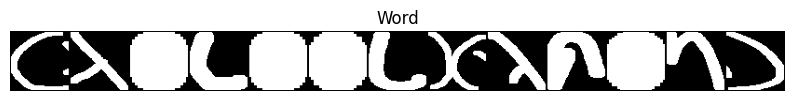

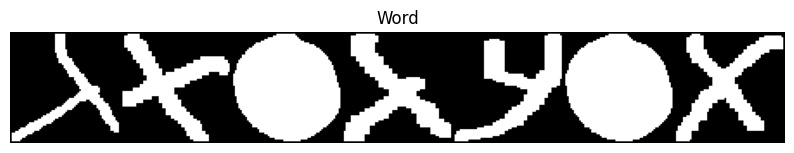

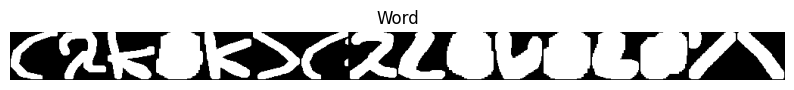

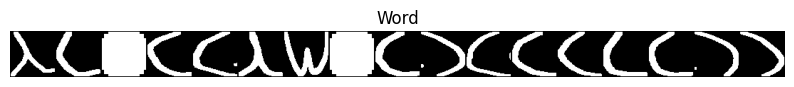

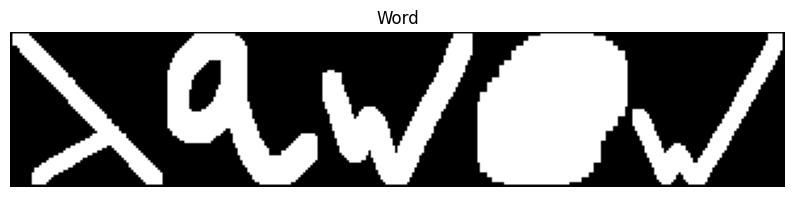

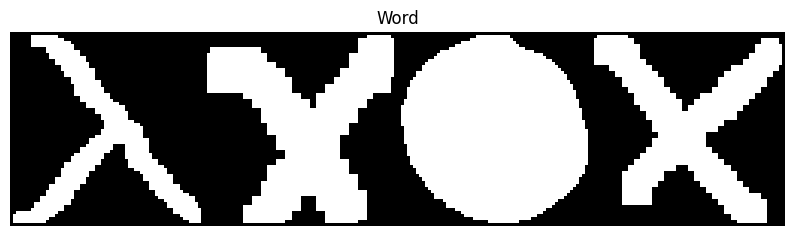

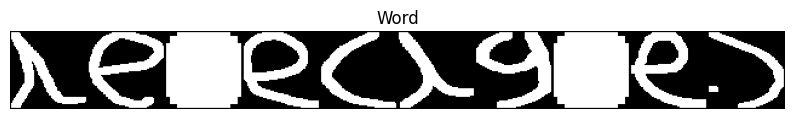

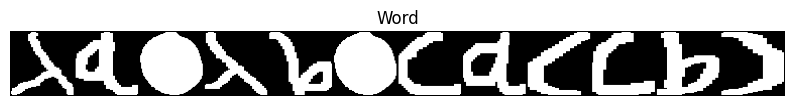

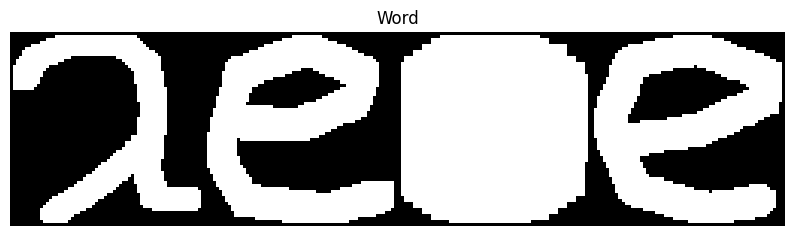

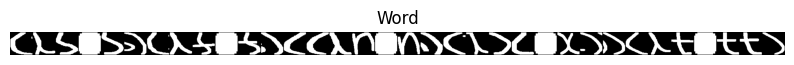

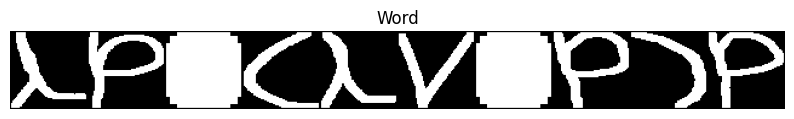

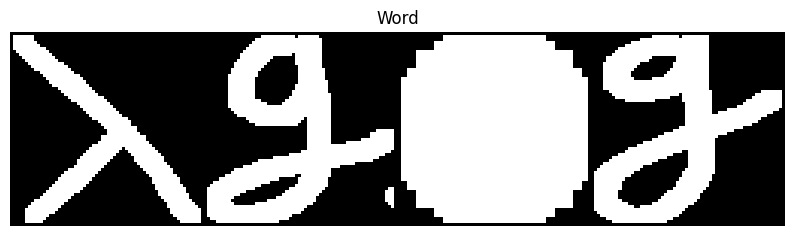

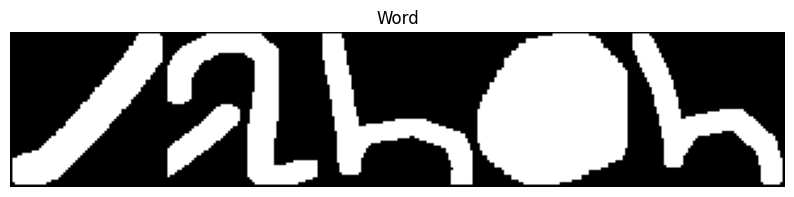

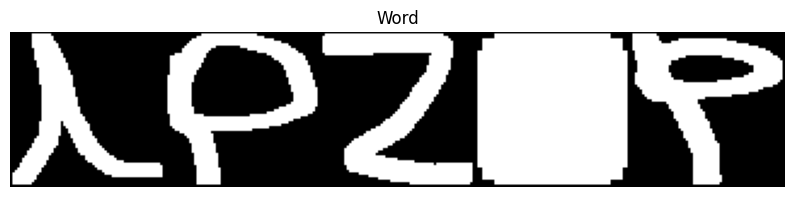

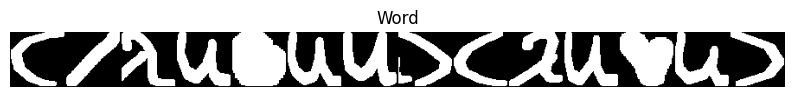

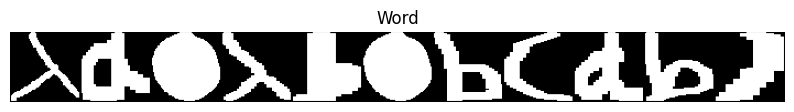

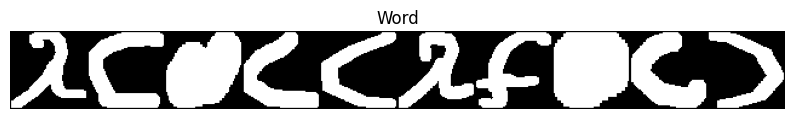

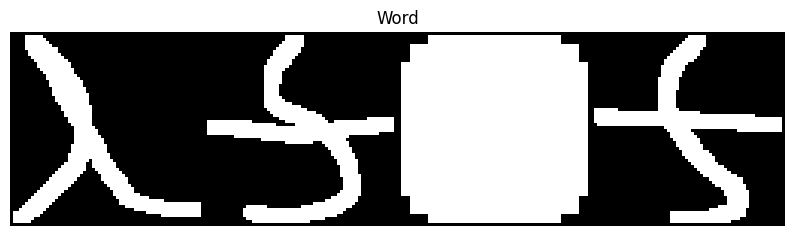

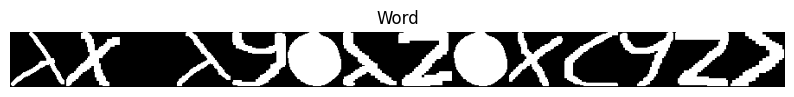

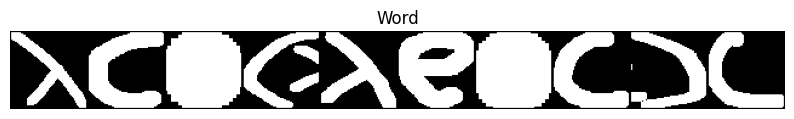

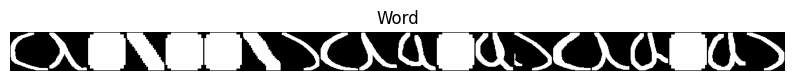

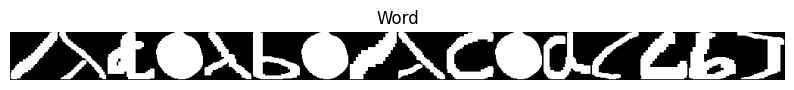

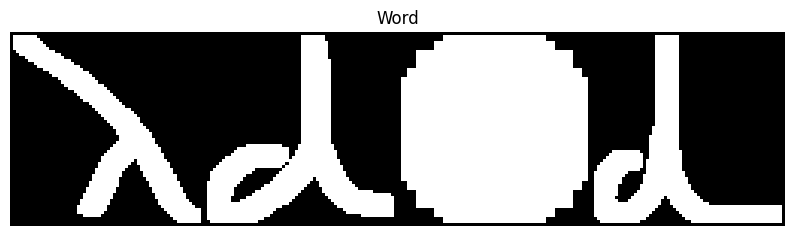

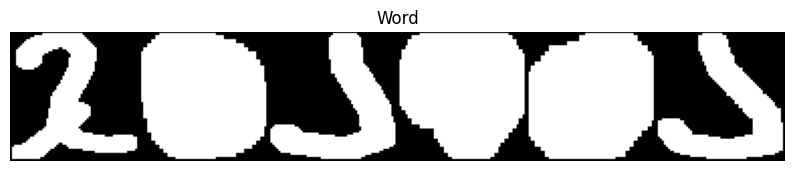

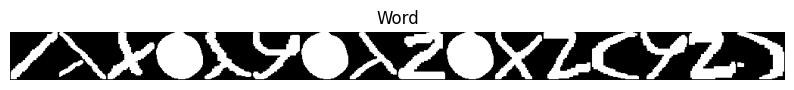

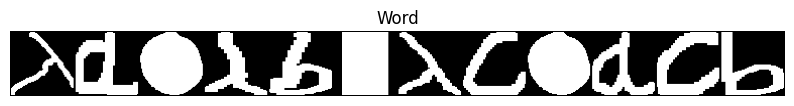

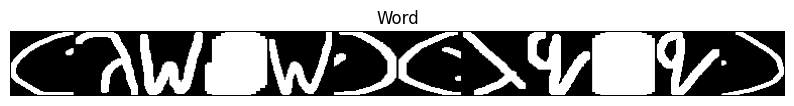

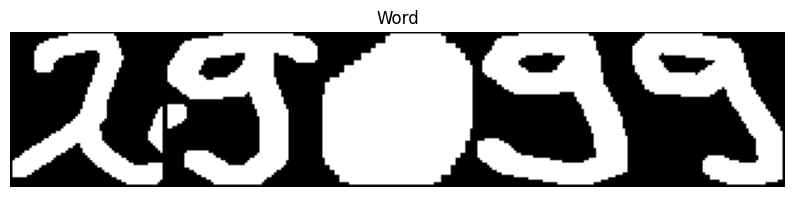

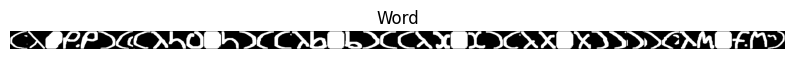

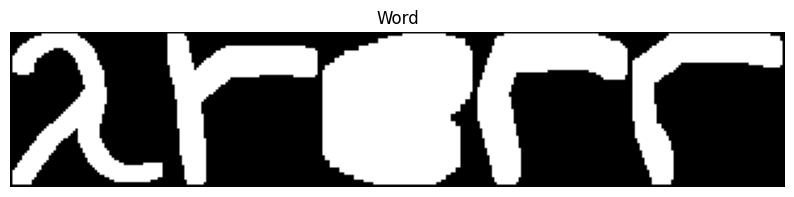

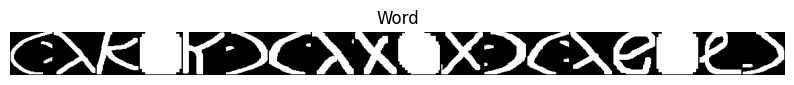

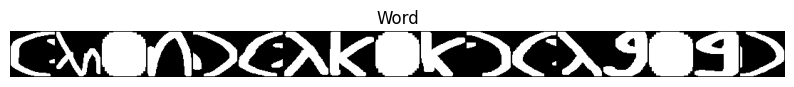

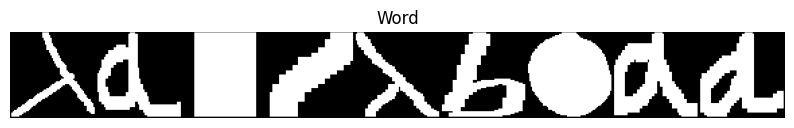

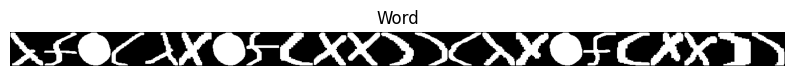

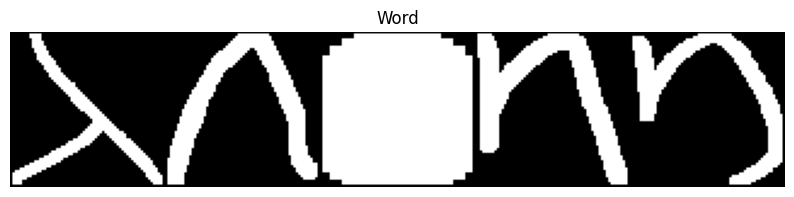

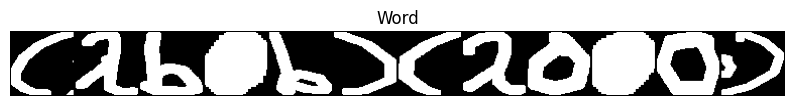

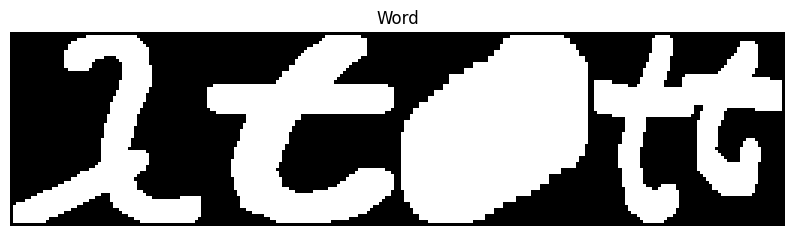

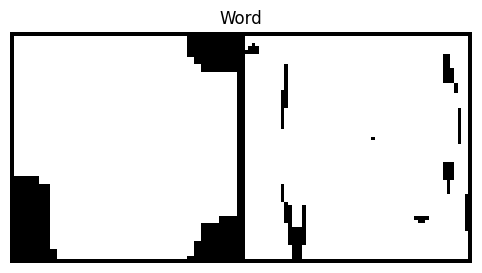

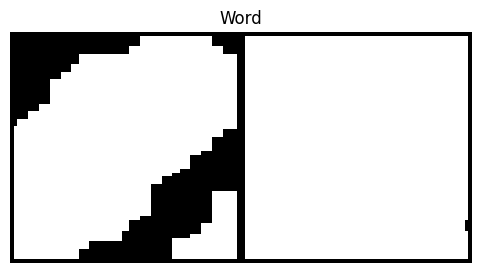

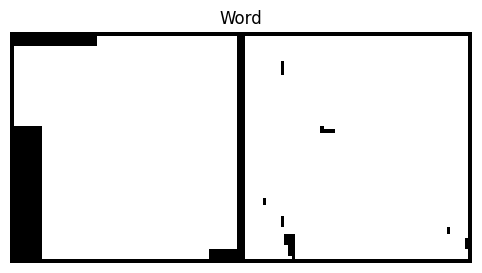

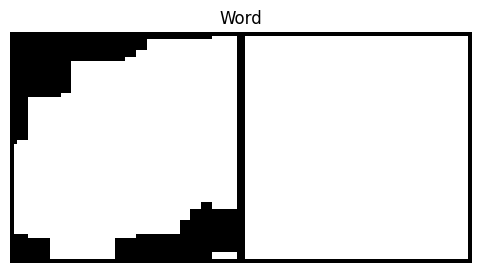

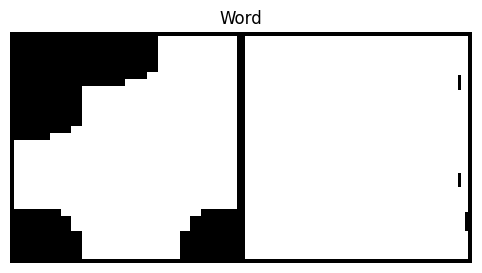

In [127]:
for word in lc_words:
    # List to hold processed 2D character images.
    char_images = []
    for char in word:
        # Assume char has shape (batch, channel, height, width) with batch=1 and channel=1.
        # Extract the image from the tensor.
        # char[0] gets rid of the batch dimension,
        # and char[0, 0, :, :] selects the channel and reduces it to a 2D array.
        char_img = char[0, :, :]
        char_images.append(char_img)

    # Check that there are any characters in the word
    if char_images:
        # Horizontally concatenate the characters.
        # Each char image is assumed to have the same height.
        word_image = np.concatenate(char_images, axis=1)

        # Create a new figure and display the concatenated word image.
        plt.figure(figsize=(10, 3))
        plt.imshow(word_image, cmap='gray')
        plt.axis('off')
        plt.title("Word")
        plt.show()